In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Crypto/test_2/FTX/FTT-USD.csv', date_parser = True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,1.501756,1.517845,1.460168,1.473047,1.473047,8396595
1,2019-12-01,1.473410,1.480934,1.425907,1.476954,1.476954,9944409
2,2019-12-02,1.476461,1.512531,1.448838,1.492000,1.492000,9514150
3,2019-12-03,1.492000,1.583356,1.492000,1.550795,1.550795,7624523
4,2019-12-04,1.550717,1.819642,1.526406,1.800696,1.800696,11150378
...,...,...,...,...,...,...,...
1092,2022-11-26,1.401195,1.429898,1.349244,1.364939,1.364939,43773375
1093,2022-11-27,1.364506,1.384601,1.315469,1.315469,1.315469,7301184
1094,2022-11-28,1.315751,1.329345,1.281961,1.295093,1.295093,6250102
1095,2022-11-29,1.294036,1.322258,1.278124,1.303769,1.303769,4903379


# **Data Pre-processing**

In [4]:
#Replace None or Null values with forward filling technique using fillna function.

data = data.fillna(method = 'ffill')

In [5]:
#Convert Date column into Datatime format

data['Date'] = pd.to_datetime(data.Date)

# **Data Visualization**

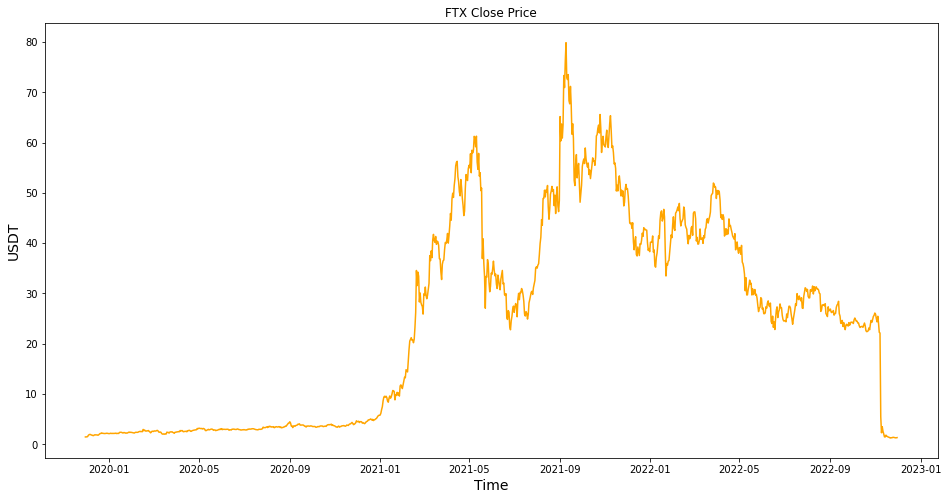

In [6]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], color="orange")
plt.title('FTX Close Price')
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

# **Data Spliting**

In [7]:
data_training = data[data['Date']< '2022-03-30'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,1.501756,1.517845,1.460168,1.473047,1.473047,8396595
1,2019-12-01,1.473410,1.480934,1.425907,1.476954,1.476954,9944409
2,2019-12-02,1.476461,1.512531,1.448838,1.492000,1.492000,9514150
3,2019-12-03,1.492000,1.583356,1.492000,1.550795,1.550795,7624523
4,2019-12-04,1.550717,1.819642,1.526406,1.800696,1.800696,11150378
...,...,...,...,...,...,...,...
846,2022-03-25,49.452240,51.429714,49.163292,49.750996,49.750996,238255458
847,2022-03-26,49.749378,50.541172,49.575539,49.919537,49.919537,94919252
848,2022-03-27,49.924557,52.203789,49.644836,51.962048,51.962048,124360636
849,2022-03-28,51.964310,53.192760,51.579144,51.725754,51.725754,159643415


In [8]:
data_test = data[data['Date']> '2022-03-30'].copy()
data_test

,Date,Open,High,Low,Close,Adj Close,Volume
852,2022-03-31,51.163799,51.691452,48.706467,48.885368,48.885368,158985625
853,2022-04-01,48.897396,51.130981,47.588886,50.493214,50.493214,161010469
854,2022-04-02,50.490658,51.185368,49.630230,49.728485,49.728485,145408272
855,2022-04-03,49.723057,51.231583,49.434307,50.456226,50.456226,100486929
856,2022-04-04,50.446308,50.446308,48.914635,50.132381,50.132381,119579446
...,...,...,...,...,...,...,...
1092,2022-11-26,1.401195,1.429898,1.349244,1.364939,1.364939,43773375
1093,2022-11-27,1.364506,1.384601,1.315469,1.315469,1.315469,7301184
1094,2022-11-28,1.315751,1.329345,1.281961,1.295093,1.295093,6250102
1095,2022-11-29,1.294036,1.322258,1.278124,1.303769,1.303769,4903379


# **Feature Engineering**

In [9]:
#feature selection
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,1.501756,1.517845,1.460168,1.473047,8396595
1,1.473410,1.480934,1.425907,1.476954,9944409
2,1.476461,1.512531,1.448838,1.492000,9514150
3,1.492000,1.583356,1.492000,1.550795,7624523
4,1.550717,1.819642,1.526406,1.800696,11150378


In [10]:
#Normalizing training_data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[3.63154354e-04, 4.41857831e-04, 4.85971445e-04, 0.00000000e+00,
        1.84635757e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.98352846e-05,
        2.24135050e-03],
       [3.90878407e-05, 3.78244477e-04, 3.25262287e-04, 2.41752790e-04,
        2.13155096e-03],
       ...,
       [6.20731143e-01, 6.07198144e-01, 6.83956178e-01, 6.44006587e-01,
        3.14396914e-02],
       [6.46863408e-01, 6.19037016e-01, 7.11393160e-01, 6.40992566e-01,
        4.04436468e-02],
       [6.43456193e-01, 6.10731044e-01, 6.95647762e-01, 6.32960743e-01,
        4.20094494e-02]])

In [11]:
#Prepare train data
X_train = []
Y_train = []

In [12]:
training_data.shape[0]

851

In [13]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])

In [14]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(791, 60, 5)

# Model Building

In [15]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 5)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 64)            704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 50)                92850     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 93,605
Trainable params: 93,605
Non-trainable params: 0
____________________________________________________

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, Y_train, epochs = 50, batch_size =32)

Epoch 1/50
25/25 [==============================] - 1s 7ms/step - loss: 0.0142
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 9.8823e-04
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 11/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 12/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/50
25/25 [==========================

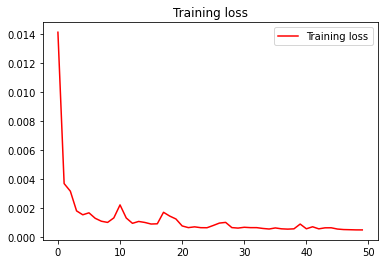

<Figure size 432x288 with 0 Axes>

In [17]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# **Performance Evaluation**

In [18]:
past_60_days = data_training.tail(60)
df= past_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,40.039131,41.884243,39.999828,41.659229,127993564
1,41.678143,41.814583,40.380924,41.095879,94281559
2,41.096771,44.032997,39.678165,43.671753,214377542
3,43.667938,48.090549,42.886517,45.241333,270307330
4,45.241692,46.133240,42.462818,42.928501,218101272


In [19]:
inputs = scaler.transform(df)
inputs

array([[ 4.94084156e-01,  4.83663907e-01,  5.47147606e-01,
         5.12590176e-01,  3.23667930e-02],
       [ 5.15082334e-01,  4.82830015e-01,  5.52553221e-01,
         5.05404431e-01,  2.37636898e-02],
       [ 5.07634095e-01,  5.09386423e-01,  5.42585012e-01,
         5.38260692e-01,  5.44114706e-02],
       ...,
       [-2.01984591e-03, -1.81465652e-03, -2.04178645e-03,
        -2.26987157e-03,  1.29858531e-03],
       [-2.29804731e-03, -1.89949428e-03, -2.09621196e-03,
        -2.15920586e-03,  9.54909612e-04],
       [-2.16733173e-03, -1.69029086e-05, -1.75194259e-03,
        -1.69844313e-03,  4.17533481e-03]])

In [20]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])

In [21]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((245, 60, 5), (245,))

In [22]:
Y_pred = model.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [23]:
print("RMSE: ", math.sqrt(mean_squared_error(Y_test,Y_pred)))
print("MSE: ", mean_squared_error(Y_test,Y_pred))
print("MAE: ", mean_absolute_error(Y_test,Y_pred))
print("R2 score:", r2_score(Y_test, Y_pred))

RMSE:  0.044066438048559836
MSE:  0.0019418509622875619
MAE:  0.025103197081364128
R2 score: 0.8871394898098346


In [24]:
scaler.scale_

array([1.28114850e-02, 1.19708984e-02, 1.41843917e-02, 1.27553838e-02,
       2.55194055e-10])

In [25]:
scale = 1/5.18164146e-05
scale

19298.903787912797

In [26]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [27]:
# Y_test = scaler.inverse_transform(Y_test)
# Y_pred = scaler.inverse_transform(Y_pred) 

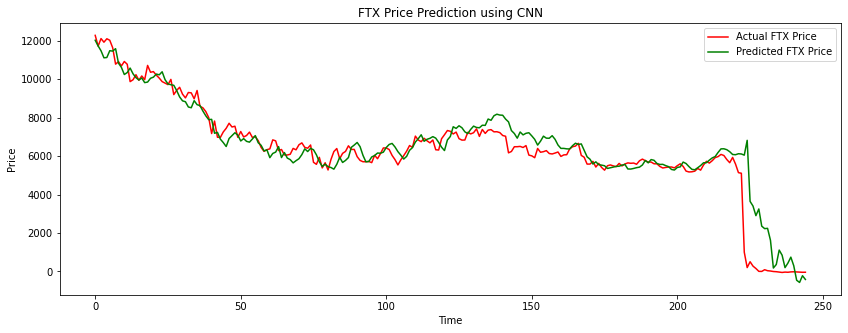

In [28]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Actual FTX Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted FTX Price')
plt.title('FTX Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()